In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

2023-06-14 14:18:03.742817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 14:18:03.790388: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 14:18:03.791335: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 14:18:04.761241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/matwey/sci/hse/venv/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = tfds.load('cats_vs_dogs', split='train', shuffle_files=True)

In [3]:
resized_ds = ds.map(lambda x: (tf.image.resize(x["image"], [224, 224]), x["label"]))

2023-06-14 14:18:06.523913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]
2023-06-14 14:18:06.524618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [8]
	 [[{{node Placeholder/_2}}]]


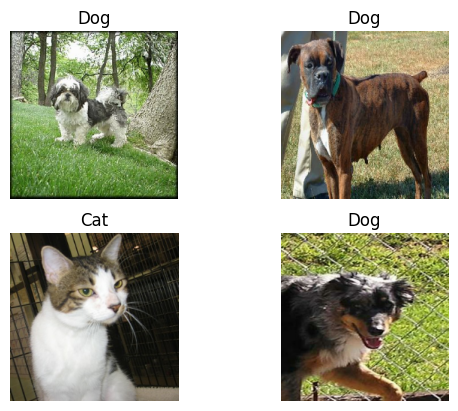

In [4]:
samples = tfds.as_numpy(resized_ds.take(4))

fig, axs = plt.subplots(2, 2)
for i, s in enumerate(samples):
    ax = axs[i // 2, i % 2]
    ax.imshow(s[0].astype(np.uint8))
    ax.axis('Off')
    ax.set_title("{}".format("Dog" if s[1] else "Cat"))

In [5]:
ds = ds.take(2048)
dataset_size = ds.cardinality().numpy()
train_size = int(0.8 * dataset_size)
test_size = int(0.2 * dataset_size)

ds = ds.shuffle(buffer_size = 1024)
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)

processed_train = ds_train.map(lambda x: (
    tf.keras.applications.resnet.preprocess_input(tf.image.resize(x["image"], [224, 224])),
    x["label"]
    )).batch(64)
processed_test = ds_test.map(lambda x: (
    tf.keras.applications.resnet.preprocess_input(tf.image.resize(x["image"], [224, 224])),
    x["label"]
    )).batch(64)

In [6]:
# Create base model
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False)
# Freeze base model
base_model.trainable = False

HIDDEN_DIM = 128
OUTPUT_DIM = 1

new_top = tf.keras.Sequential(layers = [
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(HIDDEN_DIM, activation="sigmoid"),
    tf.keras.layers.Dense(OUTPUT_DIM, activation="sigmoid"),
], name="new_top")

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
outputs = new_top(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='binary_crossentropy', metrics=['accuracy'])

fit = model.fit(processed_train, epochs=5, validation_data=processed_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 new_top (Sequential)        (None, 1)                 262401    
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/5


2023-06-14 14:18:09.354933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8]
	 [[{{node Placeholder/_1}}]]
2023-06-14 14:18:09.355632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]


26/26 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7705

2023-06-14 14:20:10.316951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-06-14 14:20:10.317889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [8]
	 [[{{node Placeholder/_4}}]]


26/26 [==============================] - 153s 6s/step - loss: 0.5623 - accuracy: 0.7705 - val_loss: 0.3683 - val_accuracy: 0.9415
Epoch 2/5
26/26 [==============================] - 147s 6s/step - loss: 0.2647 - accuracy: 0.9689 - val_loss: 0.2230 - val_accuracy: 0.9683
Epoch 3/5
26/26 [==============================] - 153s 6s/step - loss: 0.1659 - accuracy: 0.9799 - val_loss: 0.1304 - val_accuracy: 0.9854
Epoch 4/5
26/26 [==============================] - 141s 5s/step - loss: 0.1280 - accuracy: 0.9829 - val_loss: 0.0930 - val_accuracy: 0.9976
Epoch 5/5
26/26 [==============================] - 143s 6s/step - loss: 0.1043 - accuracy: 0.9841 - val_loss: 0.0909 - val_accuracy: 0.9878


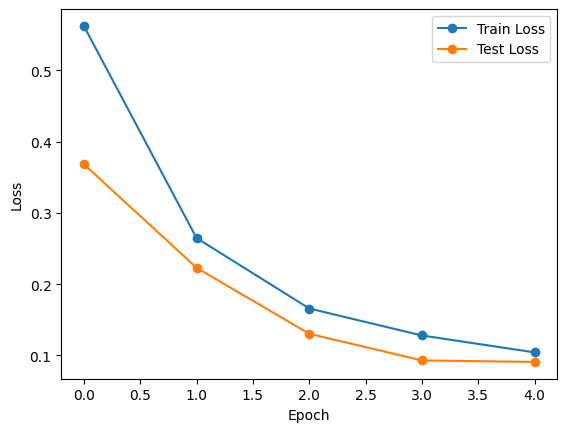

In [7]:
plt.plot(fit.history['loss'], '-o', label="Train Loss")
plt.plot(fit.history['val_loss'], '-o', label="Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

2023-06-14 14:33:03.624882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-06-14 14:33:03.625658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [8]
	 [[{{node Placeholder/_1}}]]


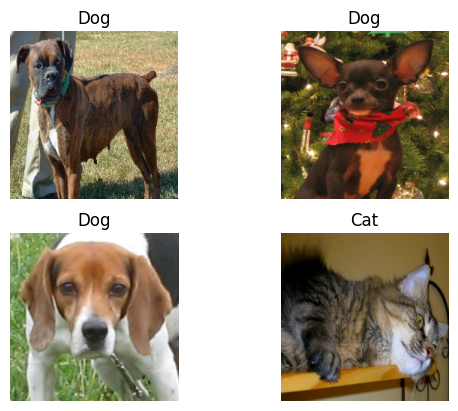

In [8]:
samples = tfds.as_numpy(resized_ds.take(4))

fig, axs = plt.subplots(2, 2)
for i, s in enumerate(samples):
    d = tf.expand_dims(tf.keras.applications.resnet.preprocess_input(tf.image.resize(s[0], [224, 224])), 0)
    p = model.predict(d, verbose=False)[0,0]
    ax = axs[i // 2, i % 2]
    ax.imshow(s[0].astype(np.uint8))
    ax.axis('Off')
    ax.set_title("{}".format("Dog" if p > 0.5 else "Cat"))

In [9]:
import sklearn.metrics

scores = []
labels = []
for x in processed_test.take(-1):
    scores.append(model.predict(x[0], verbose=False))
    labels.append(x[1].numpy())

scores = np.concatenate(scores)
labels = np.concatenate(labels)

fpr, tpr, _ = sklearn.metrics.roc_curve(labels, scores)
roc = {"tpr": tpr, "fpr": fpr}
auc = sklearn.metrics.roc_auc_score(labels, scores)

2023-06-14 14:33:05.752718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]
2023-06-14 14:33:05.753436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [8]
	 [[{{node Placeholder/_3}}]]


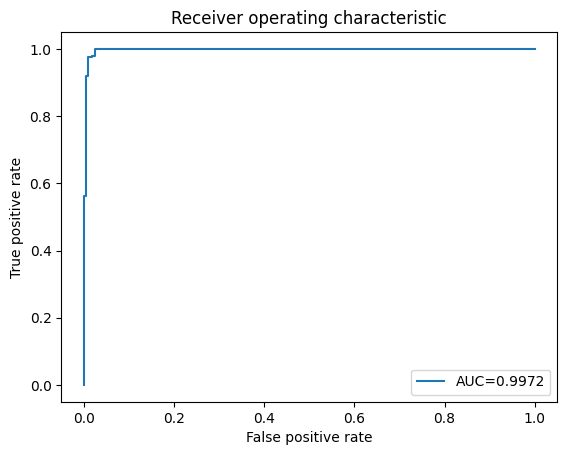

In [10]:
plt.figure()
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(roc['fpr'], roc['tpr'], label='AUC={:.4f}'.format(auc))
_ = plt.legend(loc='lower right')